# m_qubits_QVC_Breast_Cancer

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm

import scipy
from scipy.linalg import expm
import scikitplot as skplt

from h_partitioned_new import *
#from W_unitary import *
#from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

### helper functions

In [62]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        X_batches = np.split(X_train, n_batches)
        y_batches = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return X_batches, y_batches


def k_fold_split(X, y, ele_per_split, i):
    
    k_X_train = np.concatenate( (X[:ele_per_split*i, :], X[ele_per_split*(i+1):, :]) )
    k_X_test = X[ele_per_split*i:ele_per_split*(i+1), :]
    
    k_y_train = np.concatenate( (y[:ele_per_split*i], y[ele_per_split*(i+1):]) )
    k_y_test = y[ele_per_split*i:ele_per_split*(i+1)]
    
    return k_X_train, k_X_test, k_y_train, k_y_test


def PCA1(X_train, X_test, y_train, y_test, n_dimensions):
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_dimensions).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)
    
    return X_train, X_test, y_train, y_test 

def PCA2(X, y, n_dimensions):
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_dimensions).fit(X)
    X = pca.transform(X)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = X
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X = minmax_scale.transform(X)
    
    return X, y

### dataset

In [63]:
dataset = load_breast_cancer()

used_points = 350 ## Must be multiple of 70

X = dataset.data[:used_points]
y = dataset.target[:used_points]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_dimensions = 4
X_train, X_test, y_train, y_test = PCA1(X_train, X_test, y_train, y_test, n_dimensions)

n_batches = 7
X_batches, y_batches = training_split(X_train, y_train, n_batches)

## Classical SVM

### linear kernel

In [64]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

c:\Users\aglas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [65]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

print(accuracy_train)
print(accuracy_test)

0.963265306122449
0.9809523809523809


### gaussian kernel

In [66]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

In [67]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

print(accuracy_train)
print(accuracy_test)

0.9673469387755103
0.9714285714285714


## Quantum SVM (explicit approach)

In [68]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 4
d = 2
n_part = 2

init_theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(init_theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452 1.91161039 3.2971419
 2.71399059 1.82984665 3.84438512 0.87646578 1.83559896 2.30191935]


#### training

In [69]:
def MSE_loss(theta, data, labels,shots = 1024):
    
    tmp = []
    for i in range(0, len(labels)):
        if labels[i] == 0:
            tmp.append(-1)
        else:
            tmp.append(1)
    
    predictions = []
    for i in range(0, len(labels)):
        predictions.append(h(data[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - tmp[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm 

In [71]:
epochs = n_batches
shots = 1024
theta = init_theta
thetas = []
predictions = []
training_accuracies = []
testing_accuracies = []

for i in tqdm(range(0, epochs)):
    
    prediction = np.zeros(len(y_batches[i]))
    data = X_batches[i]
    labels = y_batches[i]
    print(len(data))
    for j in range(0, len(data)):
        print(j)
        prediction[j] = h(data[j],theta, n,  d, shots)
        
        objective_function = lambda theta: MSE_loss(theta, data, labels,shots)
        optimizer = SPSA(maxiter=50)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    h_subtest = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        h_subtest[j] = h(X_test[j],theta_opt, n, d, shots)
    
    train_result = 1 - ( ((sum(np.abs(2*labels-1-prediction)))/2) / len(labels) ) 
    test_result = 1 -  ( ((sum(np.abs(2*y_test-1-h_subtest)))/2) / len(y_test) ) 
    training_accuracies.append(train_result)
    testing_accuracies.append(test_result)
    
    thetas.append(theta_opt)
    predictions.append(prediction)
    theta = theta_opt

  0%|          | 0/7 [00:00<?, ?it/s]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 14%|█▍        | 1/7 [33:44<3:22:29, 2024.94s/it]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 29%|██▊       | 2/7 [1:05:26<2:42:41, 1952.32s/it]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 43%|████▎     | 3/7 [1:39:06<2:12:12, 1983.19s/it]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 57%|█████▋    | 4/7 [2:07:24<1:33:31, 1870.48s/it]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 71%|███████▏  | 5/7 [2:31:56<57:33, 1726.90s/it]  

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


 86%|████████▌ | 6/7 [2:55:58<27:09, 1630.00s/it]

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


100%|██████████| 7/7 [3:20:01<00:00, 1714.50s/it]


In [72]:
print('Training accuracies: '+ str(training_accuracies))
print('Training mean: '+ str(np.mean(training_accuracies)))
print('Testing accuracies: '+ str(testing_accuracies))
print('Testing mean: '+ str(np.mean(testing_accuracies)))

Training accuracies: [0.6, 0.6, 0.6, 0.4, 0.5142857142857142, 0.6857142857142857, 0.6285714285714286]
Training mean: 0.5755102040816327
Testing accuracies: [0.5333333333333333, 0.6190476190476191, 0.5523809523809524, 0.5904761904761905, 0.6761904761904762, 0.5904761904761905, 0.5523809523809524]
Testing mean: 0.5877551020408164


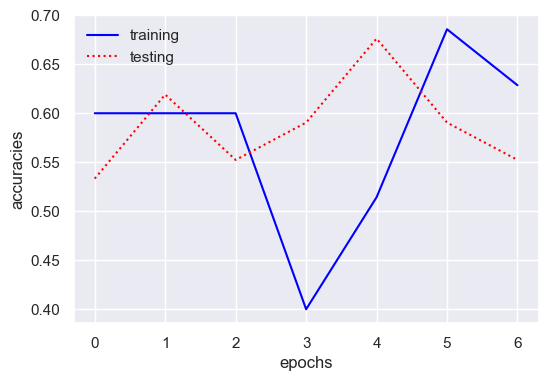

In [73]:
plt.plot(training_accuracies, color='blue', label='training')
plt.plot(testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('BC_learning_partitioned.pdf')
plt.show()

#### testing

In [74]:
tmp = []
for i in range(0, len(predictions)):
    for j in range(0, len(predictions[i])):
        tmp.append(predictions[i][j])
        
accuracy_train = 1 - ( ((sum(np.abs(2*y_train-1-tmp)))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))

Training accuracy: 0.5755102040816327


In [75]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i],theta_opt, n,  d, shots ))

accuracy_test = 1 - ( ((sum(np.abs(2*y_test-1-h_test)))/2) / len(y_test) ) 
print('Testing accuracy: '+ str(accuracy_test))

Testing accuracy: 0.5142857142857142


### Cross-Validation

### split

In [76]:
k = 10
assert len(X)%k == 0 
ele_per_split = int(len(X)/k)

### training

In [77]:
theta = init_theta
k_thetas = []
k_training_accuracies = []
k_testing_accuracies = []

for i in tqdm(range(k)):
    
    k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)
    k_X_train, k_X_test, k_y_train, k_y_test = PCA1(k_X_train, k_X_test, k_y_train, k_y_test, n_dimensions)

    objective_function = lambda theta: MSE_loss(theta, k_X_train, k_y_train,shots)
    optimizer = SPSA(maxiter=50)
    
    theta_opt = optimizer.minimize(objective_function, theta).x

    k_thetas.append(theta_opt)

    k_train_predictions = np.zeros(len(k_y_train))
    for j in range(0, len(k_y_train)):
        k_train_predictions[j] = h(k_X_train[j], theta_opt, n,  d, shots) 

    k_test_predictions = np.zeros(len(k_y_test))
    for j in range(0, len(k_y_test)):
        k_test_predictions[j] = h(k_X_test[j], theta_opt, n,  d, shots) 
        
    k_train_result = 1 - ( ((sum(np.abs(2*k_y_train-1-k_train_predictions)))/2) / len(k_y_train) )
    k_test_result = 1 - ( ((sum(np.abs(2*k_y_test-1-k_test_predictions)))/2) / len(k_y_test) )
    k_training_accuracies.append(k_train_result)
    k_testing_accuracies.append(k_test_result)

100%|██████████| 10/10 [1:21:25<00:00, 488.58s/it]


In [80]:
print('Training accuracies: '+ str(k_training_accuracies))
print('Training mean: '+ str(np.mean(k_training_accuracies)))
print('Testing accuracies: '+ str(k_testing_accuracies))
print('Testing mean: '+ str(np.mean(k_testing_accuracies)))

Training accuracies: [0.6031746031746033, 0.7714285714285715, 0.6253968253968254, 0.6412698412698412, 0.7238095238095238, 0.7079365079365079, 0.6730158730158731, 0.6571428571428571, 0.653968253968254, 0.5587301587301587]
Training mean: 0.6615873015873016
Testing accuracies: [0.5714285714285714, 0.8, 0.48571428571428577, 0.6857142857142857, 0.7714285714285715, 0.6571428571428571, 0.6571428571428571, 0.6285714285714286, 0.8, 0.5428571428571429]
Testing mean: 0.6599999999999999


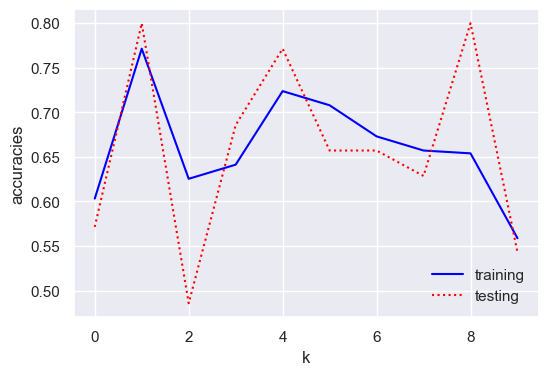

In [81]:
plt.plot(k_training_accuracies, color='blue', label='training')
plt.plot(k_testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('k')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('BC_cv_partitioned.pdf')
plt.show()

### valuation

In [82]:
max_testing_accuracy = max(k_testing_accuracies)
index = k_testing_accuracies.index(max_testing_accuracy)
k_theta_opt = k_thetas[index]

dataset = load_breast_cancer()
X_val = dataset.data[:used_points]
y_val = dataset.target[:used_points]

X_val, y_val = PCA2(X_val, y_val, n_dimensions)

h_val = np.zeros(len(y_val))
for i in range(0, len(y_val)):
    h_val[i] = h(X_val[i],k_theta_opt, n,  d, shots) 

validation_accuracy = 1 - ( ((sum(np.abs(2*y_val-1-h_val)))/2) / len(y_val) )

print("Optimal parameters: "+ str(k_theta_opt))
print("Validation accuracy: "+ str(validation_accuracy))

Optimal parameters: [2.87264892 4.85257972 5.27199999 3.91658137 0.90183167 0.88268134
 1.89686661 4.80995841 3.31487001 4.69883865 0.53601685 7.16674686
 4.56146664 1.39734197 0.73292584 2.88416392 2.2701188  3.11157479
 2.99952718 2.5638193  4.09587213 1.58671458 1.07288384 2.97244767]
Validation accuracy: 0.7771428571428571


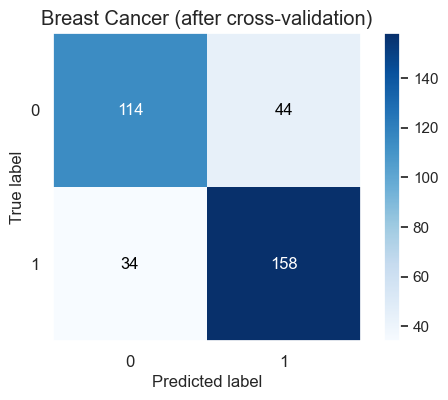

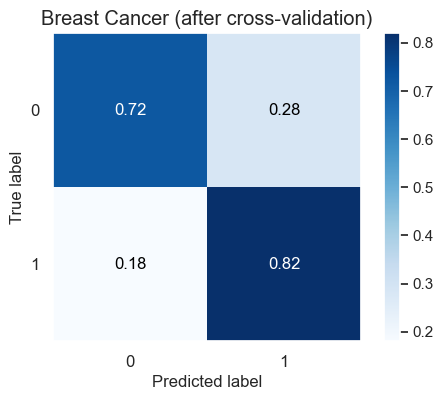

In [83]:
tmp = []
for i in range(0, len(h_val)):
    if h_val[i] == 1:
        tmp.append(1)
    else:
        tmp.append(0)
        
skplt.metrics.plot_confusion_matrix(y_val, tmp, cmap = 'Blues', title = 'Breast Cancer (after cross-validation)');
plt.savefig('BC_cf_partitioned_values.pdf')
plt.show()

skplt.metrics.plot_confusion_matrix(y_val, tmp,normalize=True, cmap = 'Blues', title = 'Breast Cancer (after cross-validation)');
plt.savefig('BC_cf_partitioned.pdf')
plt.show()
# skplt.metrics.plot_confusion_matrix(y_val, tmp, normalize=True, cmap='Blues', title = 'Moons (after cross-validation)');
# plt.savefig('Moons_cf.pdf')
# plt.show()